In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
from collections import Counter, defaultdict
import string, os, random
import plotly.graph_objs as go
import calendar
from PIL import Image 
import numpy as np
from datetime import datetime

init_notebook_mode(connected=True)

In [2]:
# Load the dataset
path = "D:/UCSD/Courses/Fall 2018/ECE 143/Project/gun-violence-data.csv"
df = pd.read_csv(path)

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['monthday'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['loss'] = df['n_killed'] + df['n_injured']

In [3]:
df.keys()

Index(['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed',
       'n_injured', 'incident_url', 'source_url',
       'incident_url_fields_missing', 'congressional_district', 'gun_stolen',
       'gun_type', 'incident_characteristics', 'latitude',
       'location_description', 'longitude', 'n_guns_involved', 'notes',
       'participant_age', 'participant_age_group', 'participant_gender',
       'participant_name', 'participant_relationship', 'participant_status',
       'participant_type', 'sources', 'state_house_district',
       'state_senate_district', 'year', 'month', 'monthday', 'weekday',
       'loss'],
      dtype='object')

In [4]:
# No. of people killed, injured, both

print("Total number of incidents = {}".format(len(df['n_killed'])))

def plot_pie_bucket(data,max_num,title):
    df['temp'] = data.apply(lambda x : str(max_num)+'+' if x>=max_num else str(x))
    tempdf = df['temp'].value_counts().reset_index()

    labels = list(tempdf['index'])
    values= list(tempdf['temp'])

    trace1 = go.Pie(labels=labels, values=values)
    layout = dict(height=600, title=title, legend=dict(orientation="h"));
    fig = go.Figure(data=[trace1], layout=layout)
    iplot(fig)
    
plot_pie_bucket(df['n_killed'],3,'Number of People Killed')
plot_pie_bucket(df['n_injured'],3,'Number of People Injured')
plot_pie_bucket(df['loss'],3,'Number of People Killed/Injured')

Total number of incidents = 239677


In [28]:
# Most serious incidents

print("\n\nThe five most serious incidents (in terms of killed+injured)".upper())

df1 = df.sort_values(['loss'], ascending=[False])
df1[['year', 'state', 'city_or_county', 'n_killed', 'n_injured']].head(5)



THE FIVE MOST SERIOUS INCIDENTS (IN TERMS OF KILLED+INJURED)


,year,state,city_or_county,n_killed,n_injured
130448,2016,Florida,Orlando,50,53
217151,2017,Texas,Sutherland Springs,27,20
101531,2015,California,San Bernardino,16,19
232745,2018,Florida,Pompano Beach (Parkland),17,17
70511,2015,Texas,Waco,9,18


In [6]:
def get_user_mapping(txt):
    if txt == "NA":
        return {}
    mapping = {}
    for d in txt.split("||"):
        try:
            key = d.split("::")[0]
            val = (d.split("::")[1]).lower()
            mapping[key] = val
        except:
            pass
    return mapping

df['participant_type'] = df['participant_type'].fillna("NA")
df['participant_type_map'] = df['participant_type'].apply(lambda x : get_user_mapping(x))
df['participant_age'] = df['participant_age'].fillna("NA")
df['participant_age_map'] = df['participant_age'].apply(lambda x : get_user_mapping(x))

In [48]:
## Finding the Suspect Age Groups

def find_type_distribution(person_type):
    suspect_age_groups = defaultdict(int)
    for _, row in df.iterrows():
        for k,v in row['participant_type_map'].items():
            if person_type in v and k in row['participant_age_map']:
                ag = row['participant_age_map'][k]
                suspect_age_groups[ag] += 1

    trace1 = go.Bar(x=list(suspect_age_groups.keys()), y=list(suspect_age_groups.values()))
    layout = dict(height=400, title=(person_type+' age histogram').upper(), xaxis=dict(range=[0, 100]), legend=dict(orientation="h"));
    fig = go.Figure(data=[trace1], layout=layout)
    iplot(fig)

In [49]:
find_type_distribution('suspect')
find_type_distribution('victim')

In [55]:
guns=df['n_guns_involved']
loss=df['loss']

for n in range(1,10):
    inds=guns==n
    print(np.mean(loss[inds]))

0.7322419794900743
0.5603851812224154
0.40920336467095497
0.39035591274397247
0.1425287356321839
0.1824561403508772
0.05603448275862069
0.051094890510948905
0.018018018018018018


In [96]:
df[ 'participant_status'].value_counts()
p_status = df["participant_status"].str.replace("[::0-9|,]","").str.upper()
p_status = p_status[p_status.notnull()]
p_status = pd.DataFrame(p_status)

types=['ARRESTED','INJURED','KILLED','UNHARMED']

for p_type in types:
    p_status[p_type]  = p_status["participant_status"].str.count(p_type)

sizes = [sum(p_status[p_type]) for p_type in types]

labels = types
values= sizes

trace1 = go.Pie(labels=labels, values=values)
layout = dict(height=600, title='Participant Type', legend=dict(orientation="h"));
fig = go.Figure(data=[trace1], layout=layout)
iplot(fig)

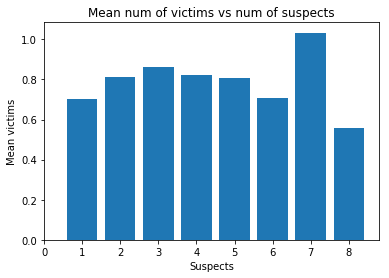

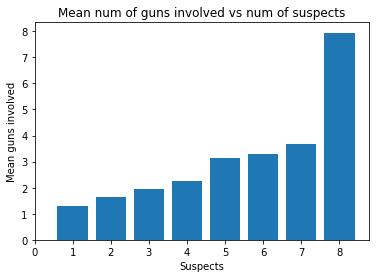

In [92]:
df['participant_type'].value_counts()
p_type = df["participant_type"].str.replace("[::0-9|,]","").str.upper()
p_type = p_type[p_type.notnull()]
p_type = pd.DataFrame(p_type)
victim  = p_type["participant_type"].str.count("VICTIM")
suspect = p_type["participant_type"].str.count("SUBJECT-SUSPECT")

x=[]
y1=[]
y2=[]
max_n=9
for n in range(1,max_n):
    inds=suspect==n
    val=np.mean(victim[inds])
    x.append(n)
    y1.append(val)
    val=np.mean(df['n_guns_involved'][inds])
    y2.append(val)
    
plt.bar(x,y1)
plt.xticks(np.arange(max_n))
plt.xlabel('Suspects')
plt.ylabel('Mean victims')
plt.title('Mean num of victims vs num of suspects')
plt.show()

plt.bar(x,y2)
plt.xticks(np.arange(max_n))
plt.xlabel('Suspects')
plt.ylabel('Mean guns involved')
plt.title('Mean num of guns involved vs num of suspects')
plt.show()